In [1]:
# https://www.kaggle.com/datasets/ealtman2019/credit-card-transactions

import numpy as np
import pandas as pd
import seaborn as sns
import statistics as st

from sklearn.preprocessing import TargetEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier

In [2]:
data_path = '../data/credit_card_transactions-ibm_v2.csv.gz'
transactions = pd.read_csv(data_path, compression = 'gzip')

In [3]:
def format_col_names(col: str) -> str:
    # Lowercase all characters and remove non-alphabetics
    return ''.join(char.lower() for char in col if char.isalpha())


def clean_data(transactions: pd.DataFrame) -> pd.DataFrame:

    # Rename columns
    col_names = {col: format_col_names(col) for col in transactions.columns}
    transactions = transactions.rename(columns = col_names)

    # Parse hour and minute data from time column
    transactions['hour'] = transactions['time'].str[0:2].astype('int64')
    transactions['minute'] = transactions['time'].str[3:5].astype('int64')

    # Convert amount to float
    transactions['amount'] = transactions['amount'].str.replace('$', '').astype('float')

    # Convert isfraud to binary
    transactions['isfraud'] = transactions['isfraud'].apply(lambda x: 1 if x == 'Yes' else 0)

    # Log transform amount to yield a less skewed distribution
    transactions['logamount'] = np.log(transactions['amount'])
    transactions['logamount'] = transactions['logamount'].fillna(0)
    transactions.loc[transactions['logamount'] == -np.inf, ['logamount']] = 0

    drop_cols = ['user', 'card', 'time', 'amount']

    return transactions.drop(columns = drop_cols)


def encode_categoricals(transactions: pd.DataFrame) -> pd.DataFrame:

    # Encode usechip, errors
    
    dummies_usechip = transactions['usechip'].str.get_dummies()
    dummies_errors = transactions['errors'].str.get_dummies(sep = ',')

    drop_cols = ['usechip', 'errors']

    return pd.concat([transactions.drop(columns = drop_cols), dummies_usechip, dummies_errors], axis = 'columns')


def balance_data(transactions: pd.DataFrame) -> pd.DataFrame:

    # Sample the data, yielding a dataset balanced on isfraud

    num_fraud = transactions.loc[transactions['isfraud'] == 1].shape[0] # 29757
    num_samples = round(0.8*num_fraud)

    fraudulent = transactions.loc[transactions['isfraud'] == 1].sample(num_samples)
    not_fraudulent = transactions.loc[transactions['isfraud'] == 0].sample(num_samples)

    return pd.concat([fraudulent, not_fraudulent])


def process_balance(transactions: pd.DataFrame) -> pd.DataFrame:

    transactions = clean_data(transactions)
    transactions = encode_categoricals(transactions)
    transactions = balance_data(transactions)

    # Shuffle data
    return transactions.sample(frac = 1)

In [4]:
transactions_processed_balanced = process_balance(transactions)

/Users/jon/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/jon/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
def target_encoding(transactions: pd.DataFrame) -> pd.DataFrame:

    # Target encoding for merchantcity, merchantstate, merchantname, zip, mcc
    # To avoid data leakage, perform this function last (after balancing)

    drop_cols = ['merchantname', 'merchantcity', 'merchantstate', 'zip', 'mcc']

    y = transactions['logamount'].to_numpy()

    for col in drop_cols:

        target_encoded = TargetEncoder().fit_transform(transactions[col].to_numpy().reshape(-1, 1), y)
        
        transactions = pd.concat([
            transactions.drop(columns = col),
            pd.DataFrame(target_encoded, columns = ['target_encoded_' + f'{col}'], index = transactions.index)
            ],
            axis = 'columns'
        )

    return transactions


def cv_fit_model(
    model,
    transactions: pd.DataFrame,
    n_splits: int,
    target_col: str
) -> tuple[list, list]:
    
    # Fit model with cross-validation

    models = []
    scores = []

    kf = KFold(n_splits = n_splits)

    for train_ind, test_ind in kf.split(transactions):

        # Perform target encoding independently on each split to avoid data leakage
        train = target_encoding(transactions.iloc[train_ind])
        test = target_encoding(transactions.iloc[test_ind])

        model.fit(train.drop(columns = [target_col]), train[target_col])
        models.append(model)

        score = model.score(test.drop(columns = [target_col]), test[target_col])
        scores.append(score)

    return (models, scores)


def gen_confusion_matrix(
    model_scores: tuple[list, list],
    transactions: pd.DataFrame,
    target_col: str
) -> ConfusionMatrixDisplay:

    # Generate a confusion matrix

    median_score = st.median(model_scores[1])
    median_ind = model_scores[1].index(median_score)
    median_model = model_scores[0][median_ind]

    return ConfusionMatrixDisplay.from_estimator(
        median_model,
        target_encoding(transactions.drop(columns = [target_col])),
        transactions[target_col],
        normalize = 'true',
        cmap = 'Blues'
    )


def gen_roc_curve(
    model_scores: tuple[list, list],
    transactions: pd.DataFrame,
    target_col: str
) -> RocCurveDisplay:

    # Generate a ROC curve

    median_score = st.median(model_scores[1])
    median_ind = model_scores[1].index(median_score)
    median_model = model_scores[0][median_ind]

    return RocCurveDisplay.from_estimator(
        median_model,
        target_encoding(transactions.drop(columns = [target_col])),
        transactions[target_col]
    )

In [6]:
# Logistic regression model

logistic_model_scores = cv_fit_model(
    LogisticRegression(solver = 'newton-cholesky'),
    transactions_processed_balanced,
    n_splits = 5,
    target_col = 'isfraud'
)

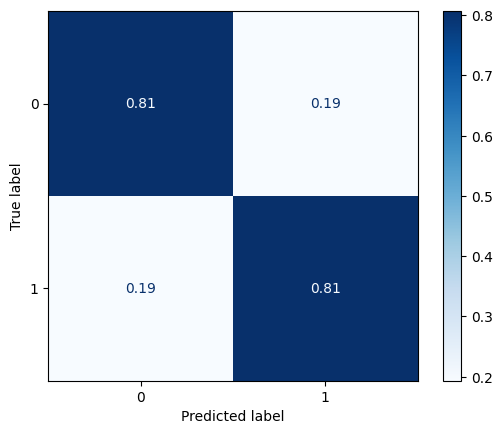

In [7]:
gen_confusion_matrix(logistic_model_scores, transactions_processed_balanced, target_col = 'isfraud')

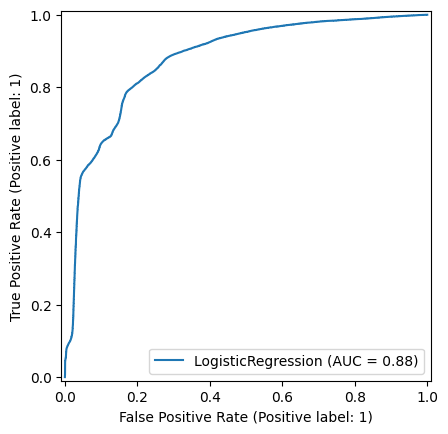

In [8]:
gen_roc_curve(logistic_model_scores, transactions_processed_balanced, target_col = 'isfraud')

In [9]:
# Histogram gradient boosting tree model

hgb_model_scores = cv_fit_model(
    HistGradientBoostingClassifier(validation_fraction = None),
    transactions_processed_balanced,
    n_splits = 5,
    target_col = 'isfraud'
)

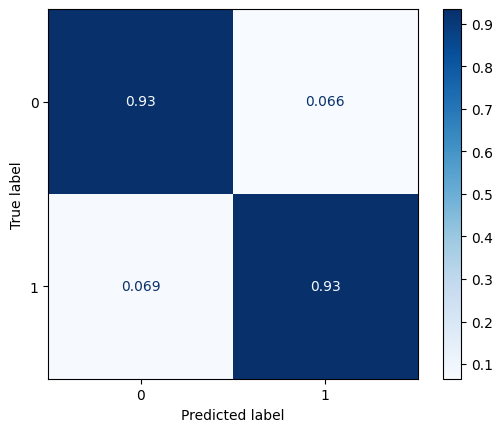

In [10]:
gen_confusion_matrix(hgb_model_scores, transactions_processed_balanced, target_col = 'isfraud')

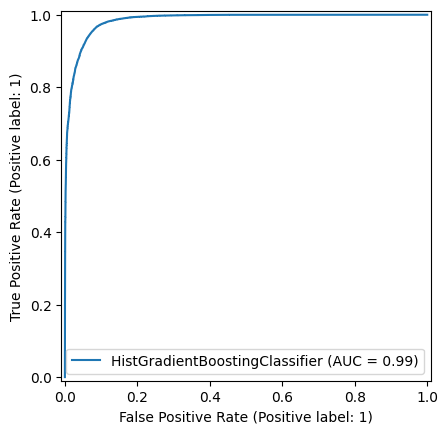

In [11]:
gen_roc_curve(hgb_model_scores, transactions_processed_balanced, target_col = 'isfraud')